# Market clearing vs midprice skew

Note: to run this notebook you will need to have access to [LOBSTER](https://lobsterdata.com/) and you will need to have follow the steps in the README.md file to populate the database with JPM data from 2nd March 2022.

In [1]:
import os
os.chdir("../")

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
import pandas as pd

from rl4mm.agents.baseline_agents import Teradactyl, FixedActionAgent
from rl4mm.database.HistoricalDatabase import HistoricalDatabase
from rl4mm.features.Features import Inventory
from rl4mm.gym.action_interpretation.OrderDistributors import BetaOrderDistributor
from rl4mm.gym.HistoricalOrderbookEnvironment import HistoricalOrderbookEnvironment
from rl4mm.gym.order_tracking.InfoCalculators import SimpleInfoCalculator
from rl4mm.gym.utils import generate_trajectory
from rl4mm.simulation.HistoricalOrderGenerator import HistoricalOrderGenerator
from rl4mm.simulation.OrderbookSimulator import OrderbookSimulator

plt.rcParams["figure.figsize"] = (10,6)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
TOTAL_VOLUME = 100
max_inventory = 250
enter_spread = False
step_size = timedelta(seconds = 5)
min_quote_level = 0
max_quote_level = 20

In [3]:
a = 1
b = 2
default_omega = Teradactyl.calculate_omega(a, b)
default_kappa = Teradactyl.calculate_kappa(a, b)

In [8]:
min_date = datetime(2015,1,5)
max_date = datetime(2015,1,7)
ticker = "TSLA"
episode_length = timedelta(minutes=10)
timesteps = np.arange(0,10,1/12)
fixed = FixedActionAgent(np.array([1,2,1,2, max_inventory]))
min_start_timedelta=timedelta(hours = 9, minutes=30)
max_end_timedelta=timedelta(hours=16, minutes=0)

In [5]:
def get_env(market_order_clearing:bool=False, market_order_fraction_of_inventory:float=0.0):
    simulator = OrderbookSimulator(
            ticker=ticker,
            order_generators=[HistoricalOrderGenerator(ticker, HistoricalDatabase())],
            n_levels=10,
            episode_length=episode_length,
        )
    order_distributor = BetaOrderDistributor(quote_levels=max_quote_level- min_quote_level, active_volume=TOTAL_VOLUME)
    info_calculator = SimpleInfoCalculator(market_order_fraction_of_inventory=market_order_fraction_of_inventory)
    return HistoricalOrderbookEnvironment(features=[Inventory()],
                                          min_date=min_date,
                                          simulator=simulator,
                                          max_date=max_date,
                                          min_start_timedelta=min_start_timedelta,
                                          max_end_timedelta=max_end_timedelta, 
                                          episode_length=episode_length,
                                          min_quote_level=min_quote_level,
                                          max_quote_level=max_quote_level,
                                          enter_spread=enter_spread,
                                          step_size = step_size,
                                          ticker= ticker,
                                          market_order_clearing=market_order_clearing,
                                          market_order_fraction_of_inventory=market_order_fraction_of_inventory, 
                                          preload_orders=True,
                                          info_calculator=info_calculator)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

trajectories = {}
market_order_types = {"no_market":(False, 0.0), "full_market":(True, 1.0), "half_market":(True,0.5)}

## Market Order Clearing

In [6]:
for name, value in market_order_types.items():
    env = get_env(value[0],value[1])
    trajectories[name] = generate_trajectory(fixed,env)

Messages being obtained. Min Date: 2015-01-05 15:24:10 Max Date: 2015-01-05 15:34:10 Ticker; TSLA
Messages :      exchange direction    price message_type ticker  \
0      NASDAQ      sell  2090100        limit   TSLA   
1      NASDAQ      sell  2089200        limit   TSLA   
2      NASDAQ       buy  2087500        limit   TSLA   
3      NASDAQ       buy  2087000     deletion   TSLA   
4      NASDAQ       buy  2086600     deletion   TSLA   
...       ...       ...      ...          ...    ...   
5641   NASDAQ      sell  2090000     deletion   TSLA   
5642   NASDAQ      sell  2091200     deletion   TSLA   
5643   NASDAQ      sell  2091100     deletion   TSLA   
5644   NASDAQ      sell  2091200        limit   TSLA   
5645   NASDAQ       buy  2088200        limit   TSLA   

                                        id                  timestamp  volume  \
0     S_L010_NASDAQ_TSLA_2015-01-05_233792 2015-01-05 15:24:10.106476     100   
1     S_L010_NASDAQ_TSLA_2015-01-05_233793 2015-01-05 15

/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/sit

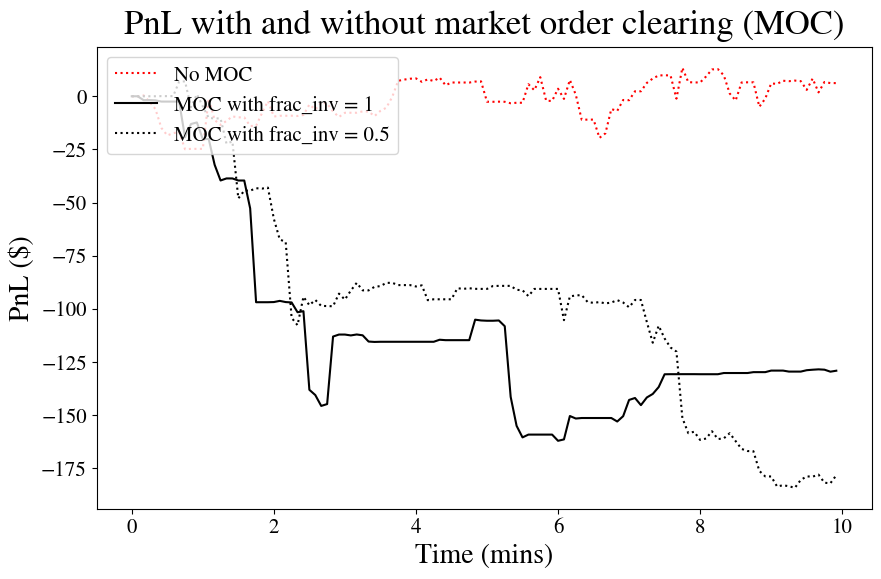

In [9]:
fig, ax_left = plt.subplots()

ax_left.plot(timesteps,np.cumsum(trajectories["no_market"]["rewards"])/10000, label = "No MOC", color='r', linestyle = ":", linewidth = 1.5)
ax_left.plot(timesteps,np.cumsum(trajectories["full_market"]["rewards"])/10000, label = r"MOC with frac_inv = 1", color='k', linestyle="-", linewidth = 1.5)
ax_left.plot(timesteps,np.cumsum(trajectories["half_market"]["rewards"])/10000, label = r"MOC with frac_inv = 0.5", color='k', linestyle=":", linewidth = 1.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel(r'PnL (\$)', fontsize=20)
plt.xlabel(r'Time (mins)', fontsize=20)
ax_left.legend(loc="upper left", fontsize=15)
plt.title(r'PnL with and without market order clearing (MOC)', fontsize=25, y = 1.01)
plt.show()

/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/sit

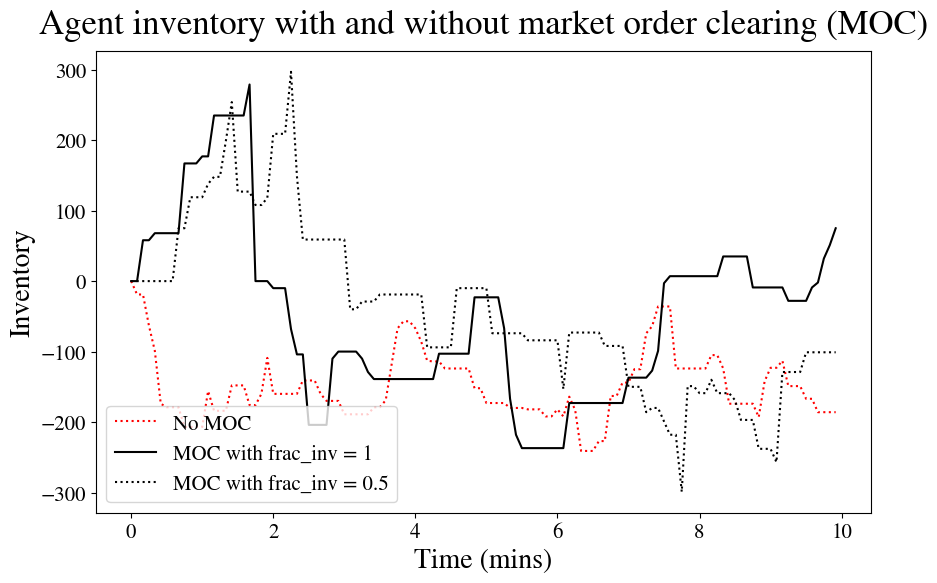

In [10]:
fig, ax_left = plt.subplots()
ax_left.plot(timesteps,np.array([info['inventory'] for info in trajectories["no_market"]["infos"]]), label = "No MOC", color='r', linestyle = ":", linewidth = 1.5)
ax_left.plot(timesteps,np.array([info['inventory'] for info in trajectories["full_market"]["infos"]]), label = r"MOC with frac_inv = 1", color='black', linestyle="-", linewidth = 1.5)
ax_left.plot(timesteps,np.array([info['inventory'] for info in trajectories["half_market"]["infos"]]), label = r"MOC with frac_inv = 0.5", color='black', linestyle=":", linewidth = 1.5)
plt.ylabel(r'Inventory', fontsize=20)
ax_left.legend(loc="lower left", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r'Time (mins)', fontsize=20)


plt.title(r'Agent inventory with and without market order clearing (MOC)', fontsize=25, y = 1.02)
plt.show()

## Teradactyl (midprice skewing agent)

In [11]:
default_kappa = 7
default_omega = 0.5
max_kappa = default_kappa*30
exponent = 2
max_inventory = 1000

In [12]:
tera = Teradactyl(max_inventory=max_inventory,
                                default_kappa = default_kappa,
                                default_omega=default_omega,
                                max_kappa=max_kappa, 
                                exponent=exponent, 
                                inventory_index=0)

In [13]:
env = get_env()

In [14]:
tera_trajectory = generate_trajectory(tera,env)

Messages being obtained. Min Date: 2015-01-07 14:57:30 Max Date: 2015-01-07 15:07:30 Ticker; TSLA
Messages :      exchange direction    price   message_type ticker  \
0      NASDAQ       buy  2116300  market_hidden   TSLA   
1      NASDAQ       buy  2114400       deletion   TSLA   
2      NASDAQ      sell  2118000          limit   TSLA   
3      NASDAQ      sell  2117500          limit   TSLA   
4      NASDAQ      sell  2118600       deletion   TSLA   
...       ...       ...      ...            ...    ...   
4676   NASDAQ      sell  2116300          limit   TSLA   
4677   NASDAQ       buy  2113400       deletion   TSLA   
4678   NASDAQ       buy  2113600          limit   TSLA   
4679   NASDAQ      sell  2115800       deletion   TSLA   
4680   NASDAQ      sell  2115800          limit   TSLA   

                                        id                  timestamp  volume  \
0     S_L010_NASDAQ_TSLA_2015-01-07_149215 2015-01-07 14:57:31.184199     100   
1     S_L010_NASDAQ_TSLA_2015-01

In [15]:
timesteps = np.arange(0,10,1/12)


/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/sit

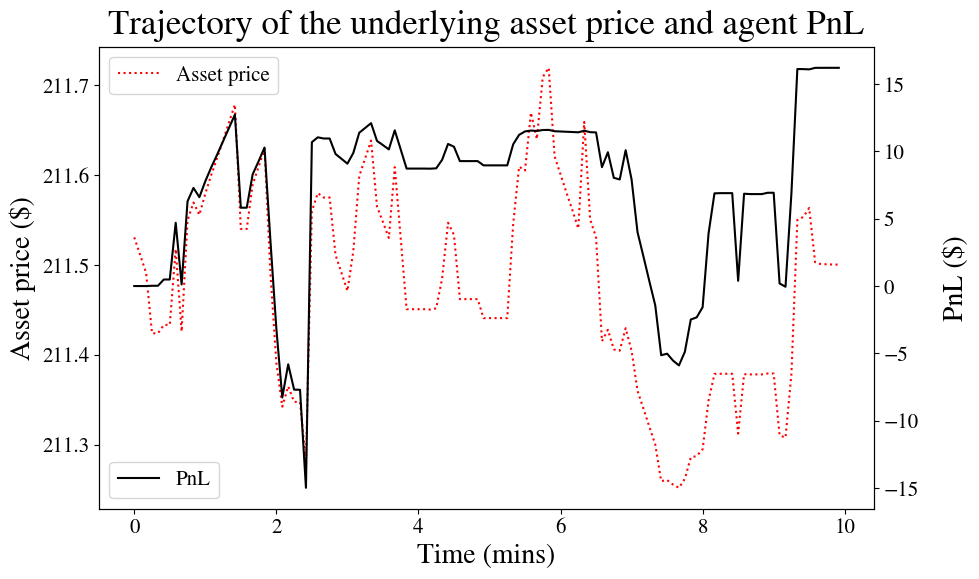

In [16]:
fig, ax_left = plt.subplots()
ax_left.plot(timesteps,np.array([info["asset_price"] for info in tera_trajectory["infos"]])/10000, label = "Asset price", color='r', linestyle = ":", linewidth = 1.5)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel(r'Asset price (\$)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r'Time (mins)', fontsize=20)

ax_right = ax_left.twinx()

ax_right.plot(timesteps,np.cumsum(tera_trajectory["rewards"])/10000, label = "PnL", color='k', linestyle="-", linewidth = 1.5)
ax_left.legend(loc="upper left", fontsize=15)
ax_right.legend(loc="lower left", fontsize=15)
plt.ylabel(r'PnL (\$)', fontsize=20)
ax_right.yaxis.set_label_coords(1.09, 0.5)

plt.title(r'Trajectory of the underlying asset price and agent PnL', fontsize=25, y = 1.01)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sasrey/miniconda3/envs/jjerome/lib/python3.11/sit

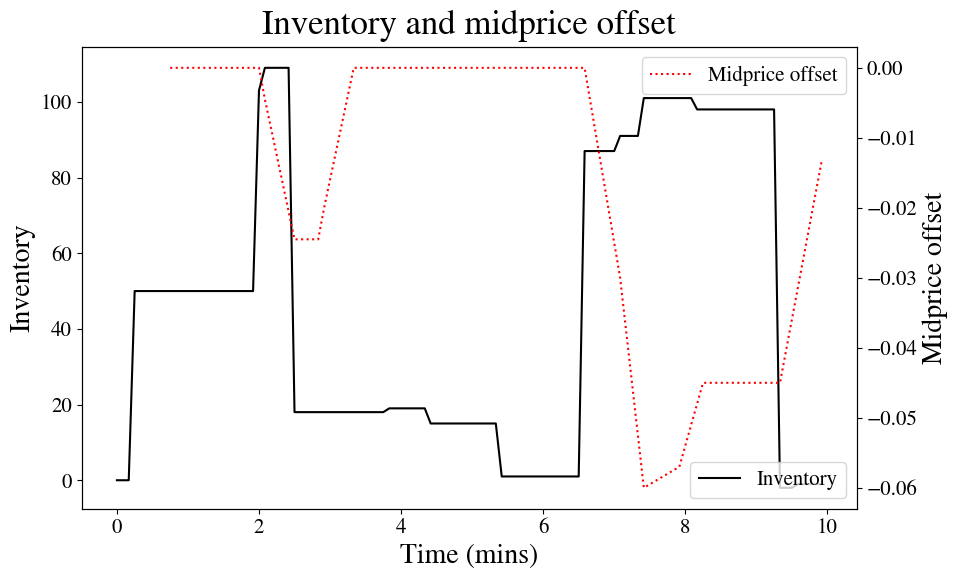

In [17]:
fig, ax_left = plt.subplots()
ax_left.plot(timesteps,np.array([info['inventory'] for info in tera_trajectory["infos"]]), label = "Inventory", color='k', linestyle = "-")

plt.ylabel(r'Inventory', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r'Time (mins)', fontsize=20)
ax_right = ax_left.twinx()

ax_right.plot(timesteps[9:],moving_average(np.array([info['weighted_midprice_offset'] for info in tera_trajectory["infos"]]),10), label = 'Midprice offset', color='r', linestyle=":")
ax_left.legend(loc="lower right", fontsize=15)
ax_right.legend(loc="upper right", fontsize=15)
plt.ylabel(r'Midprice offset', fontsize=20)

plt.title("Inventory and midprice offset", fontsize=25, y = 1.01)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Takeaways
- kappa needs to be quite high for the agent to successfully clear inventory.
- Perhaps kappa should increase in absolute inventory as well as omega
- should the default omega increase with step size?
- State dependent omega and kappa?